In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family']='kalpurush'
import re
#from collections import Counter
import itertools

In [43]:
data=pd.read_csv('../data.csv')

In [44]:
data.columns

Index(['Text', 'Sentiment'], dtype='object')

In [45]:
data.isnull().any()

Text          True
Sentiment    False
dtype: bool

In [46]:
data=data.dropna()

Checking for class ration of the data set

In [47]:
data.groupby(['Sentiment']).count()

,Text
Sentiment,
0.0,7942
1.0,3184
2.0,3872


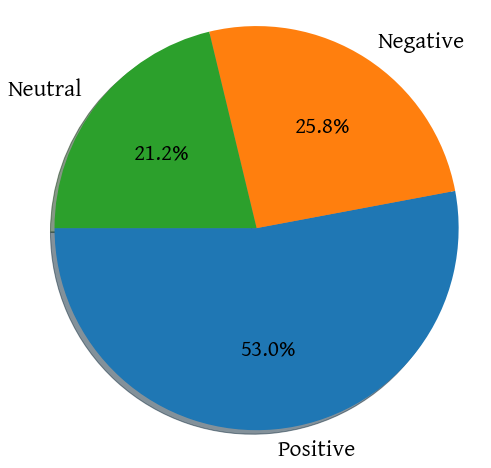

In [48]:
lab = ['Positive','Negative','Neutral']
val = data['Sentiment'].value_counts()
p,t,a=plt.pie(val, labels=lab, autopct='%1.1f%%',shadow=True, startangle=180)
for i in range(3):
    t[i].set_fontsize(24)
    a[i].set_fontsize(24)
plt.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

As we can see the data set is slightly imblanced 





In [29]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

Making a list with english stop words

In [30]:
from nltk.corpus import stopwords
stopWord=stopwords.words('english')
stopWord.extend(['islam', 'hasan', 'md','khan','rahman','ahmed','hossain','chowdhuri','alam','\ufeff'])

Adding bangla stop word to the stopWord list

In [31]:
with open('../banglaStopword.txt','r') as file:
    for line in file :
        stopWord.append(re.sub('\n','',line))

I made a small slangword file for treating all slang word as one word (the word is 'Negative')

In [32]:
slangWord=[]
with open('../slangword.txt','r') as file:
    for line in file :
        slangWord.append(re.sub('\n','',line))

As the data ses consist with bangla,romanaized and english word  there are many word with same meaning,word like 'kn' 'keno' 'ক্যান'  'কেন' are all have same meaning with different presentation ,so i make a small file to find synnonyms word 

In [33]:
synonyms={}
with open('../synonyms.txt','r') as file:
    for line in file :
        tmp=re.sub('\n','',line)
        tmp=tmp.split()
        synonyms[tmp[0]]=tmp[1]

Let's make a bangla to english dictionary . 'ভাল' and 'good' should treat as one single word 

In [34]:
dic={}
i=0
with open('../BengaliDictionary_17.txt','r') as file:
    for line in file :
        tmp=re.sub('[\|\n]',' ',line)
        tmp=tmp.split()
        try :
            dic[tmp[1]]=tmp[0]
            i+=1
        except IndexError:
            #print(tmp)
            continue 

with open('../BengaliDictionary_93.csv','r') as file:
    for line in file :
        tmp=re.sub('\n','',line)
        tmp=tmp.split(',')
        if tmp[1] not in dic:
            dic[tmp[1]]=tmp[0]

In [35]:
def redundant_letters(Text):
    Text=list(Text)
    i=0
    
    ''' sometime we extra letters to express our emotion . 'Likeeeeeeee' & 'Likeee'
     both carry same value (positive sentiment),but both are writen in different
     way,so if we don't convert them into a single word,then model will treat them as a
     individual word  . The while loop will take care of those word,and convert 
     them into 'likee', and later stemeer.stem will convert them into 'like' '''


    while i<(len(Text)-2):
        #print(i,Text[i])
        if Text[i]==Text[i+1] and Text[i].isalpha():
            for j in range(i+2,len(Text)):
                if Text[i]==Text[j]:
                    Text[j]=''
                else :
                    i=j
                    break
        i+=1
    Text=str(''.join(Text).lower())
    Text1=Text.encode('unicode-escape')
    
    '''Emoji is a good way to express people emotion . 
        for emoji retrieve, if we convert a emoji in bytes then it's length become 
        10,different class of emoji has different combination. Example : all happy 
        emoji has 160 on their byte,and all sad emoji has 161 on their byte '''


    if len(Text1)>9 and Text1[1]==85:
        x=Text1[8]
        if x==48:
            Text='positive'
        elif x==49 or x==50:
            Text='negative'

#checking for synonyms 

    if Text in synonyms:
        Text=synonyms[Text]
        
#checking for stop words
    if Text in stopWord:
        return ''
    
#checking for slang Words

    if Text in slangWord:
        Text='negative'
        
#checking for bangla word,if it's a bangla word & it also exit on our dictionary

    if len(Text)!=len(Text1) and Text in dic:
        return stemmer.stem(dic[Text])
    
    elif  len(Text)==len(Text1): #for english & romanized bangla word
        return stemmer.stem(Text)
    else : #for those bangla words which don' exit on our dictionary
        return Text

In [37]:
def func(sentence):
    if type(sentence) !=str:
        return ''
    sentence=re.sub("http\S+",'',sentence)
    sentence=re.sub("@\S+",'',sentence)
    sentence=re.sub("\ufeff",'',sentence)
    sentence=re.sub('[0-9০-৯]+\S+','',sentence)
    sentence=re.sub("[-(),!?@\'\`\"\_:.+-=;*$&#%।ঃ]",' ',sentence)
    sentence=re.sub("\n",' ',sentence)
    #print(sentence)
    tmp=[redundant_letters(word) for word in sentence.split()]
    tmp=[word for word in tmp if len(word.encode('unicode-escape'))>2]
    #print(' '.join(tmp))
    return ' '.join(tmp)

In [49]:
data['Text']=data['Text'].apply(lambda x: func(x))

In [50]:
data[:5]

,Text,Sentiment
0,case came week earlier expect look exact onlin...,0.0
1,noth special say screen protector work okay ca...,0.0
2,big guy samsung note stick lot back clip broke...,1.0
3,say peopl buy product much cheaper one sold ap...,0.0
4,guess product packag receiv bent screen protec...,1.0


# Hypothesis

people usally donn't write more than 50 word for a review (whether it positive or negative ), so there is a possibility that sample that consist with more than 70-80 words would be neutral. Lets find out

In [51]:
neutral_data=data['Text'][data['Sentiment']==2]
positive_data=data['Text'][data['Sentiment']==0]
negative_data=data['Text'][data['Sentiment']==1]
neutral_length=[len(i.split()) for i in neutral_data]
positive_length=[len(i.split()) for i in positive_data]
negative_length=[len(i.split()) for i in negative_data]

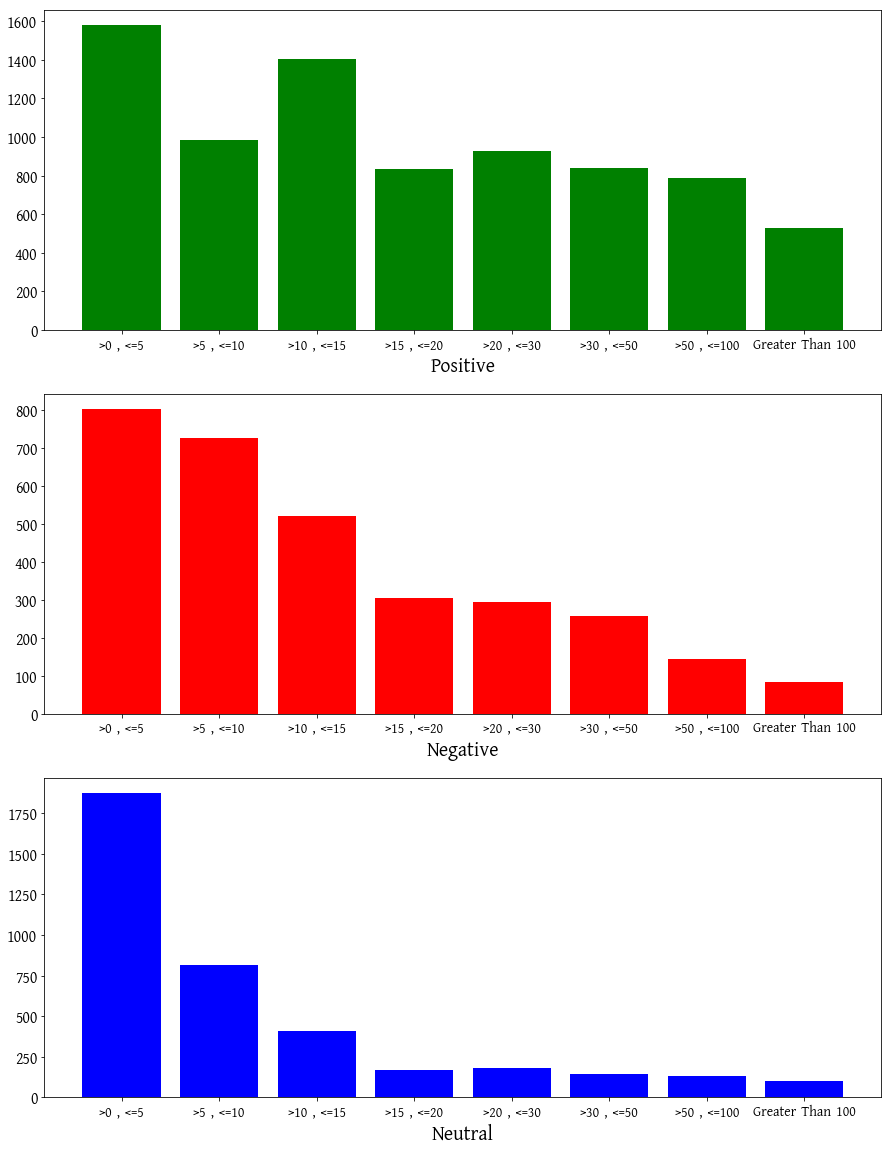

In [52]:
lim=[5,10,15,20,30,50,100]
lim1=[]
neutral_X=[]
positive_X=[]
negative_X=[]
a=0
for i in lim:
    tmp=[j for j in neutral_length if j>a and j<=i]
    neutral_X.append(len(tmp))
    tmp=[j for j in positive_length if j>a and j<=i]
    positive_X.append(len(tmp))
    tmp=[j for j in negative_length if j>a and j<=i]
    negative_X.append(len(tmp))
    lim1.append('>%d , <=%d' %(a,i))
    a=i
    
tmp=[j for j in neutral_length if j>100]
neutral_X.append(len(tmp))
tmp=[j for j in positive_length if j>100]
positive_X.append(len(tmp))
tmp=[j for j in negative_length if j>100]
negative_X.append(len(tmp))

lim1.append('Greater Than 100')

plt.figure(figsize=(15,20))

plt.subplot(311)
plt.xlabel('Positive',fontsize=20)
plt.bar(range(8),positive_X,color='g')
plt.xticks(range(8),lim1,fontsize=14)
plt.yticks(fontsize=16)

plt.subplot(312)
plt.xlabel('Negative',fontsize=20)
plt.bar(range(8),negative_X,color='r')
plt.xticks(range(8),lim1,fontsize=14)
plt.yticks(fontsize=16)

plt.subplot(313)
plt.xlabel('Neutral',fontsize=20)
plt.bar(range(8),neutral_X,color='b')
plt.xticks(range(8),lim1,fontsize=14)
plt.yticks(fontsize=16)

plt.show()

As we can see, there are many positive and negative sample consist with more than 100 words, that means our hypothisis is not correct.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

In [54]:
train=data["Text"].tolist()
train_labels=data['Sentiment'].tolist()

In [55]:
x_train,x_test,y_train,y_test=train_test_split(train,train_labels,test_size=.1,random_state=123)

In [56]:
tfidf_vec=TfidfVectorizer(tokenizer=lambda x: x.split(),min_df=5)
x_train_tfidf=tfidf_vec.fit_transform(x_train)
x_test_tfidf=tfidf_vec.transform(x_test)

In [57]:
print('Vocab Size : ',len(tfidf_vec.vocabulary_.items()))

Vocab Size :  4217


In [58]:
model_tfidf=LogisticRegression(solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=123)
model_tfidf.fit(x_train_tfidf,y_train)
predicted_tfidf=model_tfidf.predict(x_test_tfidf)

In [59]:
print(classification_report(y_test,predicted_tfidf))
print('Accuracy: %.2f%%'%(accuracy_score(y_test,predicted_tfidf)*100))

             precision    recall  f1-score   support

        0.0       0.81      0.87      0.84       792
        1.0       0.73      0.52      0.61       325
        2.0       0.63      0.67      0.65       383

avg / total       0.74      0.75      0.74      1500

Accuracy: 74.67%


In [60]:
def plot_confusion_matrix(cm, classes,title,cmap=plt.cm.Set2):
    a=plt.imshow(cm, interpolation='nearest')
    plt.title(title, fontsize=30)
    plt.colorbar(fraction=.045)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt ='.2f'
    thresh = 50

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        tmp=cm[i, j]*100/sum(cm[i])
        plt.text(j, i,format(tmp,fmt), horizontalalignment="center", 
                 color="white" if tmp<thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

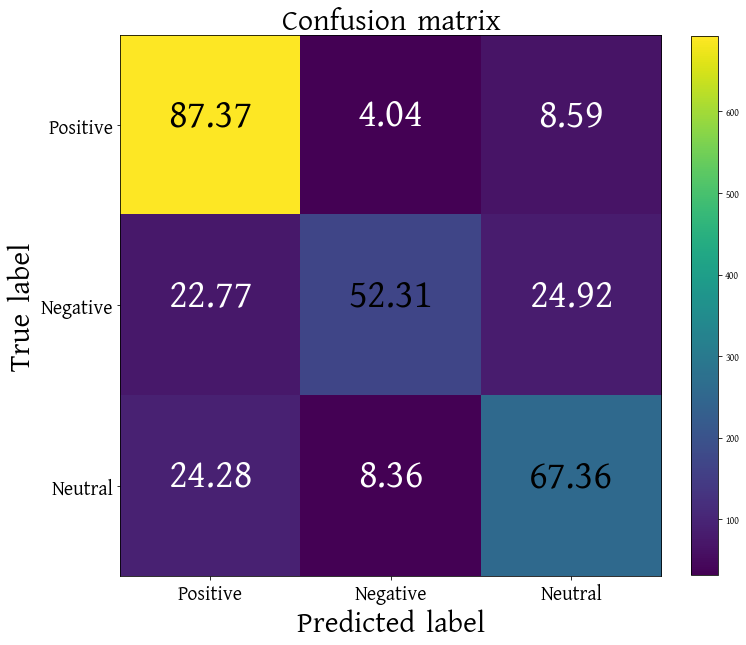

In [61]:
cm=confusion_matrix(y_test,predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Positive','Negative','Neutral'],title='Confusion matrix')
plt.show()

Let's find out the most important word for our model 

In [62]:
def important_features(vectorizer, model, n=5):
    index_to_word = {idx:word for word,idx in vectorizer.vocabulary_.items()}

    classes ={}
    for class_idx in range(model.coef_.shape[0]):
        word_importances = [(val, index_to_word[word_idx]) for word_idx,val in enumerate(model.coef_[class_idx])]
        sorted_coeff = sorted(word_importances)
        bottom  = sorted_coeff[:n]
        bottom.reverse()
        top = sorted_coeff[-n:]
        classes[class_idx] = {
            'tops':top,
            'bottom':bottom
        }
    return classes


In [63]:
importance =important_features(tfidf_vec,model_tfidf,10)

In [64]:
def plot_important_words(data, name,n):
    y_pos = np.arange(n)

    top_scores = [a[0] for a in data[0]['tops']]
    top_words = [a[1] for a in data[0]['tops']]
    fig = plt.figure(figsize=(15, 15))  
    #print(top_scores,bottom_scores)
    
    
    plt.subplot(131)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5,color='green')
    plt.title('positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=17)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    
    top_scores = [a[0] for a in data[1]['tops']]
    top_words = [a[1] for a in data[1]['tops']]
    plt.subplot(132)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5,color='red')
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=17)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    top_scores = [a[0] for a in data[2]['tops']]
    top_words = [a[1] for a in data[2]['tops']]
    plt.subplot(133)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5,color='blue')
    plt.title('Neutral', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=17)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

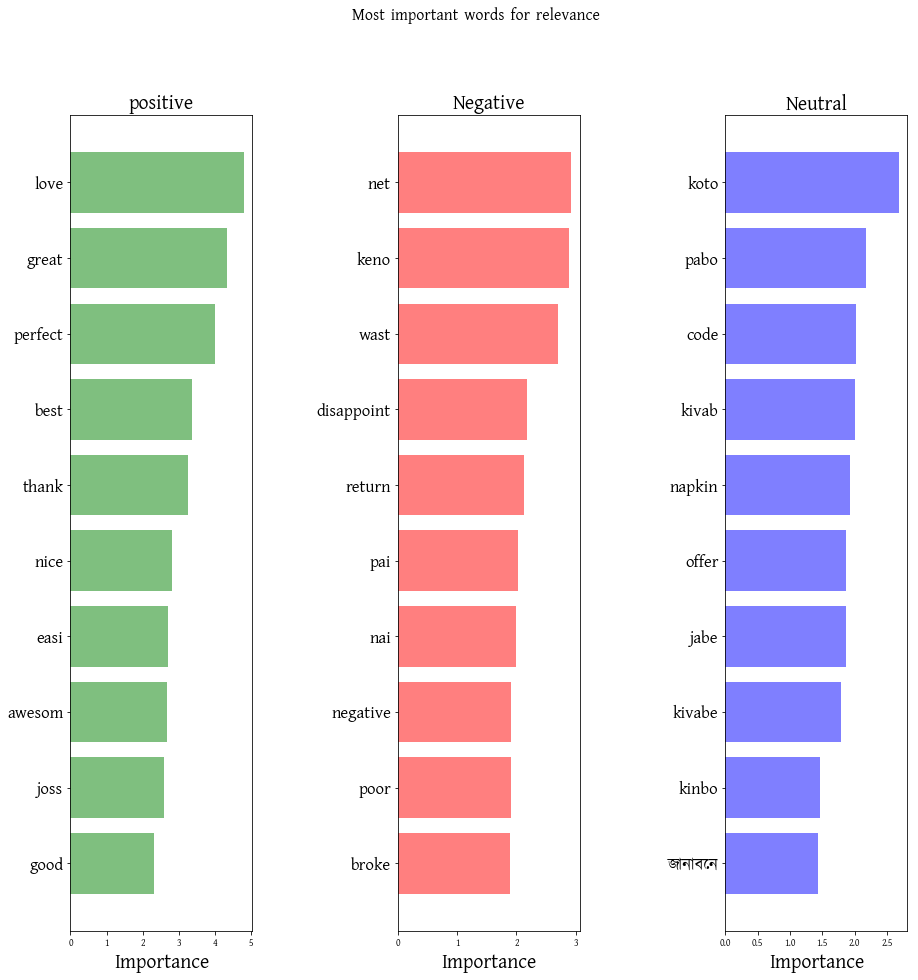

In [65]:
plot_important_words( importance,"Most important words for relevance",10)

Our model is picking some good relavent word

In [45]:
test_res=model_tfidf.predict(tfidf_vec.transform(test))
result_tfidf=pd.DataFrame({'Id':testdata['Id'],'Sentiment':test_res})
result_tfidf.to_csv('../datashall/result_tfidf.csv',header=True,index=False)

Let's start with RNN . we will use LSTM

In [36]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ModelCheckpoint
from keras import regularizers

/home/aninda/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [37]:
tokeniz=Tokenizer()
tokeniz.fit_on_texts(x_train)
train_seq=tokeniz.texts_to_sequences(x_train)
val_seq=tokeniz.texts_to_sequences(x_test)
y_train_=to_categorical(y_train)
y_val=to_categorical(y_test)
max_len=150
x_train_pad=pad_sequences(train_seq,maxlen=max_len)
x_val_pad=pad_sequences(val_seq,maxlen=max_len)
vocab_size=len(tokeniz.word_counts)+1

In [56]:
model = Sequential()
model.add(Embedding(vocab_size,200,input_shape=(max_len,),mask_zero=True ))
model.add(Dropout(.5))
model.add(LSTM(100, activation='relu',kernel_initializer='glorot_uniform',
               kernel_regularizer=regularizers.l2(0.001),bias_initializer="zeros"))
#model.add(LSTM(50, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_initializer="zeros"))
model.add(Dropout(.5))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 150, 200)          4248800   
_________________________________________________________________
dropout_9 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 303       
Total params: 4,369,503
Trainable params: 4,369,503
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy'
                  , metrics=['accuracy'])

filepath = 'model/model-ep{epoch:03d}-acc{acc:.3f}-val_acc{val_acc:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_pad,y_train_,validation_data=[x_val_pad,y_val],epochs=10,batch_size=150,callbacks=[checkpoint])

Train on 13498 samples, validate on 1500 samples
Epoch 1/10
13498/13498 [==============================] - 108s 8ms/step - loss: 1.0286 - acc: 0.5816 - val_loss: 0.8546 - val_acc: 0.6580

Epoch 00001: val_acc improved from -inf to 0.65800, saving model to model/model-ep001-acc0.582-val_acc0.658.h5
Epoch 2/10
13498/13498 [==============================] - 96s 7ms/step - loss: 0.8040 - acc: 0.6960 - val_loss: 0.7690 - val_acc: 0.6960

Epoch 00002: val_acc improved from 0.65800 to 0.69600, saving model to model/model-ep002-acc0.696-val_acc0.696.h5
Epoch 3/10
13498/13498 [==============================] - 91s 7ms/step - loss: 0.6826 - acc: 0.7533 - val_loss: 0.7136 - val_acc: 0.7153

Epoch 00003: val_acc improved from 0.69600 to 0.71533, saving model to model/model-ep003-acc0.753-val_acc0.715.h5
Epoch 4/10
13498/13498 [==============================] - 91s 7ms/step - loss: 0.6043 - acc: 0.7851 - val_loss: 0.7105 - val_acc: 0.7313

Epoch 00004: val_acc improved from 0.71533 to 0.73133, savi

In [46]:
from keras.models import load_model

In [58]:
model=load_model('./model/model-ep008-acc0.858-val_acc0.734.h5')

In [48]:
res_lstm=model.predict_classes(x_val,batch_size=150)
